Initializing easylearn_main_gui...
run_fun...
After re-sampling, the sample size are: [(0, 96), (1, 96)]
After re-sampling, the sample size are: [(0, 96), (1, 96)]
After re-sampling, the sample size are: [(0, 96), (1, 96)]
After re-sampling, the sample size are: [(0, 96), (1, 96)]
After re-sampling, the sample size are: [(0, 96), (1, 96)]

accuracy=0.77

sensitivity=0.76

specificity=0.78

auc=0.83



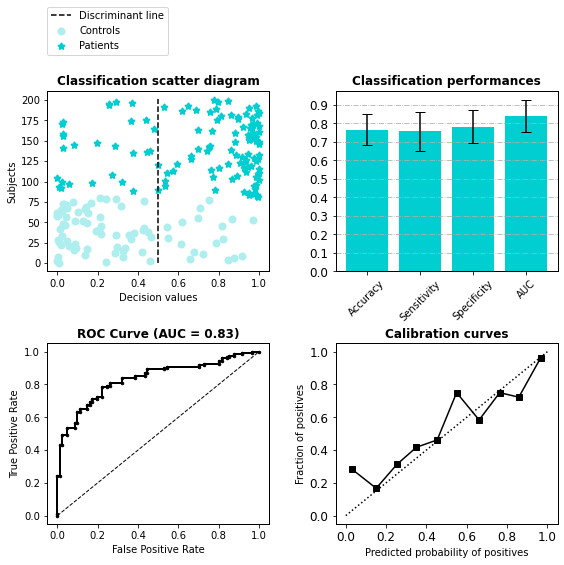

In [ ]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

"""
Main GUI of the easylearn

Author:
------
Chao Li <lichao19870617@gmail.com>
Mengshi Dong <dongmengshi1990@163.com>

License: MIT
"""


import sys
import time
import os
import json
import cgitb
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWidgets import QApplication, qApp, QMainWindow, QMessageBox, QFileDialog, QInputDialog, QLineEdit, QSplashScreen
from PyQt5.QtGui import QIcon, QPixmap
from PyQt5.Qt import QCoreApplication
from PyQt5.Qt import QThread
from PyQt5.QtCore import pyqtSignal, QMutex

from easylearn_main_gui import Ui_MainWindow
from easylearn_data_loading_run import EasylearnDataLoadingRun
from easylearn_feature_engineering_run import EasylearnFeatureEngineeringRun
from easylearn_machine_learning_run import EasylearnMachineLearningRun
from easylearn_model_evaluation_run import EasylearnModelEvaluationRun
from eslearn.stylesheets.PyQt5_stylesheets import PyQt5_stylesheets
from eslearn.base import BaseMachineLearning
from eslearn.machine_learning.classification.classification import Classification
from eslearn.machine_learning.regression.regression import Regression


class EasylearnMainGUI(QMainWindow, Ui_MainWindow):
    """Main GUI of the easylearn.
    """
    
    def __init__(self):
        print("Initializing easylearn_main_gui...")
        QMainWindow.__init__(self)
        Ui_MainWindow.__init__(self)
        self.setupUi(self)
        self.working_directory = None
        self.configuration_file = ""
        self.textBrowser.setText("Hi~, I'm easylearn. I hope I can help you finish this project successfully\n")

        # Display start progress
        self.start_process()

        # Set working_directory and debug
        if self.working_directory:
            cgitb.enable(format="text", display=1, logdir=os.path.join(self.working_directory, "log_data_loading"))
        else:
            cgitb.enable(display=1, logdir=None) 

        # Set appearance
        try:
            self.set_run_appearance()
        except ModuleNotFoundError:
            # Using other style
            with open(r'..\stylesheets\style.qrc', 'r') as f:
                sheet = f.read()
            self.setStyleSheet(sheet)
            # Warning users
            lib_root = os.path.dirname(os.__file__)
            pyqt5_stylesheets_file  = "site-packages/eslearn/stylesheets/PyQt5_stylesheets"
            pyqt5_stylesheets_path = os.path.join(lib_root, pyqt5_stylesheets_file)
            QMessageBox.warning(
                self, "Warning", f"Skin can not be used due to you did not install PyQt5_stylesheets!\nOpen terminal in the follow directory\n<{pyqt5_stylesheets_path}>, then input command 'python setup.py install' to install PyQt5_stylesheets"
            )

        # Connecting to functions
        self.select_working_directory.triggered.connect(self.select_workingdir_fun)
        self.create_configuration_file.triggered.connect(self.initialize_configuration_fun)
        self.choose_configuration_file.triggered.connect(self.load_configuration_fun)
        self.data_loading.clicked.connect(self.data_loading_fun)
        self.feature_engineering.clicked.connect(self.feature_engineering_fun)
        self.machine_learning.clicked.connect(self.machine_learning_fun)
        self.model_evaluation.clicked.connect(self.model_evaluation_fun)
        self.run.clicked.connect(self.run_fun)
        self.quit.clicked.connect(self.closeEvent_button)

        # Skin
        self.skins = {"Dark": "style_Dark", "Black": "style_black", "DarkOrange": "style_DarkOrange", 
                    "Gray": "style_gray", "Blue": "style_blue", "Navy": "style_navy", "Classic": "style_Classic"}
        self.actionDark.triggered.connect(self.set_run_appearance)
        self.actionBlack.triggered.connect(self.set_run_appearance)
        self.actionDarkOrange.triggered.connect(self.set_run_appearance)
        self.actionGray.triggered.connect(self.set_run_appearance)
        self.actionBlue.triggered.connect(self.set_run_appearance)
        self.actionNavy.triggered.connect(self.set_run_appearance)
        self.actionClassic.triggered.connect(self.set_run_appearance)

    def start_process(self):
        splash = QSplashScreen(QtGui.QPixmap("../logo/logo-upper.ico"))
        splash.showMessage("... 0%", QtCore.Qt.AlignHCenter | QtCore.Qt.AlignBottom, QtCore.Qt.black)
        splash.resize(200,90)
        splash.show()
        QtWidgets.qApp.processEvents()
        self.progress(splash)
        splash.show()
        splash.finish(self)

    def progress(self, sp):
        for i in range(1, 10):
            time.sleep(0.2)
            sp.showMessage(f"Initializing... {(i+1)*10}%", QtCore.Qt.AlignHCenter |QtCore.Qt.AlignBottom, QtCore.Qt.black)
            QtWidgets.qApp.processEvents()

    def set_run_appearance(self):
        qss_logo = """#logo{background-color: black;
                border: 2px solid white;
                border-radius: 20px;
                border-image: url('../logo/logo-lower.jpg');
                }
                #logo:hover {border-radius: 0px;}
        """

        self.logo.setStyleSheet(qss_logo)
        self.setWindowTitle('easylearn')
        self.setWindowIcon(QIcon('../logo/logo-upper.jpg'))

        # Run Icon
        self.run.setIcon(QIcon("../logo/run.png"));
        self.run.setIconSize(QPixmap("../logo/run.png").size());
        self.run.resize(QPixmap("../logo/run.png").size());
        # Close Icon
        self.quit.setIcon(QIcon("../logo/close.png"));
        self.quit.setIconSize(QPixmap("../logo/close.png").size());
        self.quit.resize(QPixmap("../logo/close.png").size())

        # Skin
        sender = self.sender()
        if sender:
            if (sender.text() in list(self.skins.keys())):
                self.setStyleSheet(PyQt5_stylesheets.load_stylesheet_pyqt5(style=self.skins[sender.text()]))
                if sender.text() == "Classic":
                    self.setStyleSheet("")
            else:
                self.setStyleSheet(PyQt5_stylesheets.load_stylesheet_pyqt5(style="style_Dark"))
        else:
            self.setStyleSheet(PyQt5_stylesheets.load_stylesheet_pyqt5(style="style_Dark"))

    def select_workingdir_fun(self):
        """
        This function is used to select the working working_directory, then change directory to this directory.
        """
        
        #  If has selected working working_directory previously, then I set it as initial working working_directory.
        if not self.working_directory:
            self.working_directory = QFileDialog.getExistingDirectory(self, "Select a working_directory", os.getcwd()) 
            self.textBrowser.setText("Current working directory is " + self.working_directory + "\n")
        else:
            self.working_directory = QFileDialog.getExistingDirectory(self, "Select a working_directory", self.working_directory) 
            self.textBrowser.setText("Current working directory is " + self.working_directory + "\n")

    def initialize_configuration_fun(self):
        """Create file to save settings

        This function will add the configuration_file to self
        """
        
        if self.working_directory:
            configuration_file_name, ok = QInputDialog.getText(self, "Initialize configuration", "Please name the configuration file:", QLineEdit.Normal, "configuration_file.json")
            if ok:
                self.configuration_file = os.path.join(self.working_directory, configuration_file_name)
                with open(self.configuration_file, 'w') as configuration_file:
                    config = {
                        "data_loading": {}, 
                        "feature_engineering": {}, 
                        "machine_learning": {}, 
                        "model_evaluation": {}, 
                    }
                    config = json.dumps(config, indent=4)
                    configuration_file.write(config)
                    config_message = "Configuration file is " + self.configuration_file
                    self.textBrowser.setText(config_message)
        else:
            QMessageBox.warning( self, 'Warning', 'Please choose a working directory first! (press button at the top left corner)')

    def load_configuration_fun(self):
        """Load configuration
        """
        if self.working_directory:
            working_directory =  self.working_directory
        else:
            working_directory =  os.getcwd()
            
        self.configuration_file, filetype = QFileDialog.getOpenFileName(self,  
                                "Select configuration file",  
                                working_directory, "Text Files (*.json);;All Files (*);;") 

        # Read configuration_file if already selected
        if self.configuration_file != "": 
            with open(self.configuration_file, 'r') as config:
                self.configuration = config.read()
            # Check the configuration is valid JSON, then transform the configuration to dict
            # If the configuration is not valid JSON, then give configuration and configuration_file to ""
            try:
                self.configuration = json.loads(self.configuration)
                self.textBrowser.setText("Configuration file is " + self.configuration_file)
            except json.decoder.JSONDecodeError:
    
                QMessageBox.warning( self, 'Warning', f'{self.configuration_file} is not valid JSON')
                self.configuration_file = ""
        else:

            QMessageBox.warning( self, 'Warning', 'Configuration file was not selected')

    def data_loading_fun(self):
        """This function is called when data_loading button is clicked.

        Then, this function will process the data loading.
        """

        self.data_loading = EasylearnDataLoadingRun(self.working_directory)
        self.data_loading.show()

    def feature_engineering_fun(self):
        """This function is called when feature_engineering button is clicked.

        Then, this function will process the feature_engineering.
        """
        
        self.feature_engineering = EasylearnFeatureEngineeringRun(self.working_directory)
        self.feature_engineering.show()

    def machine_learning_fun(self):
        """This function is called when machine_learning button is clicked.

        Then, this function will process the data loading.
        """
        
        self.machine_learning = EasylearnMachineLearningRun(self.working_directory)
        self.machine_learning.show()

    def model_evaluation_fun(self):
        """This function is called when model_evaluation button is clicked.


        Then, this function will process the model evaluation.
        """
        
        self.model_evaluation = EasylearnModelEvaluationRun(self.working_directory)
        self.model_evaluation.show()

    def run_fun(self):
        """This function is called when data_loading button is clicked.

        Then, this function will process the data loading in another thread [class Run].
        """
        
        which_ml_type_dict = {"Classification":Classification, 
                              "Regression": Regression,
        }
        
        baseml = BaseMachineLearning(self.configuration_file)
        baseml.get_all_inputs()
        ml_type = baseml.machine_learning_type_[0]

        print('run_fun...')
        if self.configuration_file == "":
            raise ValueError("You have to specify a configuration file\n")
        else:
            out_dir = self.working_directory if self.working_directory else os.path.dirname(self.configuration_file)
            model = which_ml_type_dict[ml_type](configuration_file=self.configuration_file, out_dir=out_dir)
            model.main_run()
            # self.run = Run(which_ml_type_dict[ml_type], self.configuration_file)
            # self.run.start()   

    def closeEvent(self, event):
        """This function is called when exit icon of the window is clicked.

        This function make sure the program quit safely.
        """
        
        # Set qss to make sure the QMessageBox can be seen
        reply = QMessageBox.question(self, 'Quit',"Are you sure to quit?",
                                     QMessageBox.Yes | QMessageBox.No, QMessageBox.No)

        if reply == QMessageBox.Yes:
            event.accept()
        else:
            event.ignore()

    def closeEvent_button(self, event):
        """This function is called when quit button is clicked.

        This function make sure the program quit safely.
        """
        
        # Set qss to make sure the QMessageBox can be seen
        reply = QMessageBox.question(self, 'Quit',"Are you sure to quit?",
                                     QMessageBox.Yes | QMessageBox.No, QMessageBox.No)

        if reply == QMessageBox.Yes:
            QCoreApplication.quit()


class Run(QThread):
    """Run machine learning
    """

    run_signal = pyqtSignal(str)
    

    def __init__(self, ml_model, configuration_file):
        super().__init__()
        self.ml_model = ml_model
        self.configuration_file = configuration_file
        self.run_mut = QMutex()

    def run(self):
        """This function is called when data_loading button is clicked.

        Then, this function will process the data loading.
        """
        
        self.run_mut.lock()
        model = self.ml_model(self.configuration_file)
        model.main_run()
        self.run_mut.unlock()
        # self.run_signal.emit("Finished!")


if __name__=='__main__':
    app=QApplication(sys.argv)
    md=EasylearnMainGUI()
    md.show()
    sys.exit(app.exec_())
    input()

